In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, MultiTaskLassoCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
from scipy.stats import mode

In [3]:
train = pd.read_csv('./data/X_train.csv')
test =  pd.read_csv('./data/X_test.csv')

In [4]:
print("f")

f


In [5]:
def train_validation_split(df,
                       train_size=0.6,
                       validation_size=0.2,
                       test_size=0.2,
                       traj_size=257,
                       method="random",
                       random_state=None):
    """
    Split un DataFrame en train, validation et test en respectant les trajectoires.

    Paramètres:
        df: DataFrame à splitter
        train_size, validation_size, test_size: fractions de trajectoires pour chaque split
        traj_size: nombre de lignes par trajectoire
        method: "random" (par défaut) ou d'autres méthodes à définir
        random_state: pour reproductibilité(seed)
    Retour:
        train_df, val_df, test_df
    """
    if random_state is not None:
        np.random.seed(random_state)

    n_traj = len(df) // traj_size
    if n_traj * traj_size != len(df):
        raise ValueError(f"Le DataFrame n'est pas divisible par {traj_size} (taille actuelle: {len(df)})")

    if train_size + validation_size + test_size > 1.0:
        raise ValueError("La somme de train_size, validation_size et test_size doit être <= 1.0")

    traj_indices = np.arange(n_traj)

    if method == "random":
        np.random.shuffle(traj_indices)
    else:
        raise NotImplementedError(f"Méthode {method} non implémentée pour l'instant")

    n_train = int(train_size * n_traj)
    n_val = int(validation_size * n_traj)
    n_test = int(test_size * n_traj)

    # Ajustement si n_train + n_val + n_test < n_traj
    n_remaining = n_traj - (n_train + n_val + n_test)
    n_train += n_remaining  # on ajoute le reste au train

    train_idx = traj_indices[:n_train]
    val_idx = traj_indices[n_train:n_train+n_val]
    test_idx = traj_indices[n_train+n_val:n_train+n_val+n_test]

    train_df = pd.concat([df.iloc[i*traj_size:(i+1)*traj_size] for i in train_idx])
    val_df = pd.concat([df.iloc[i*traj_size:(i+1)*traj_size] for i in val_idx])
    test_df = pd.concat([df.iloc[i*traj_size:(i+1)*traj_size] for i in test_idx])

    return train_df, val_df, test_df


In [6]:
def replicate_initial_position_by_block(df):
    coords = ["x_1", "y_1",
              "x_2", "y_2",
              "x_3", "y_3"]

    copy = df.copy()
    data = copy[coords].values
    t_values = copy["t"].values

    # Détecter le début des blocs
    block_starts = np.where(t_values == 0)[0]
    block_starts = np.append(block_starts, len(df))  # ajouter fin du dernier bloc

    # Répliquer la position initiale pour chaque bloc
    for i in range(len(block_starts) - 1):
        start, end = block_starts[i], block_starts[i + 1]
        data[start:end] = data[start]  # réplication vectorisée

        # Dernière ligne : ne copier que si t == 10
        last_idx = end - 1
        if t_values[last_idx] != 10:
            data[last_idx] = copy.iloc[last_idx][coords].values

    copy[coords] = data
    return copy

In [7]:
def validate_poly_regression_v2( X_train,  y_train,  X_val, y_val, regressor=None,degrees= range(1, 9)) :
    """
    Validation of polynomial regression models with different degrees.
    """

    best_rmse = float('inf')
    best_degree = 0
    best_pipeline = None
    rmse_values = []

    # Use Linear Regression as default regressor if none provided
    if regressor is None:
        base_regressor = LinearRegression()

    elif regressor is RidgeCV:
        # Instanciez RidgeCV avec des hyperparamètres pour la validation croisée interne
        base_regressor = RidgeCV(
            alphas=np.logspace(-6, 3, 10),
            scoring='neg_mean_squared_error',
            cv=5
        )

    # -Iterate over each degree
    for degree in degrees:

        # 1. Define the pipeline
        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('scaler', StandardScaler()),
            ('regressor', base_regressor)
        ])

        # 2. Train the model
        pipeline.fit(X_train, y_train)

        # Print the number of features
        n_features = pipeline['poly'].n_output_features_
        print(f"Degree: {degree}, Number of features: {n_features}")

        # 3 Predict on validation set
        y_val_pred = pipeline.predict(X_val)

        # 4. Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        rmse_values.append((degree, rmse))

        # 5. Save the best model
        if rmse < best_rmse:
            best_rmse = rmse
            best_degree = degree
            best_pipeline = pipeline

    print(f"\nBest Degree: {best_degree} with RMSE: {best_rmse:.4f}")
    return best_rmse,best_degree



In [8]:
# --- CONFIGURATION ---
NUM_TRAJECTORIES_TO_SAMPLE = 50
LINES_PER_TRAJECTORY = 257
NUM_RUNS = 10
best_result = [] 
total_trajectories_available = len(train) // LINES_PER_TRAJECTORY

print(f"--- Starting Distribution Analysis ({NUM_RUNS} Runs) ---")

# --- STEP 1: FIXED SAMPLING (Outside the Loop) ---
random_trajectory_indices = np.random.choice(
    total_trajectories_available,
    size=NUM_TRAJECTORIES_TO_SAMPLE,
    replace=False
)

sample_rows = []
for traj_index in random_trajectory_indices:
    start = traj_index * LINES_PER_TRAJECTORY
    end = start + LINES_PER_TRAJECTORY
    sample_rows.extend(range(start, end))

sampled_data_fixed = train.iloc[sample_rows]

--- Starting Distribution Analysis (10 Runs) ---


Fixed raw sample created (size: 12850 rows).

--- Run 1/10 ---
Degree: 1, Number of features: 7
Degree: 2, Number of features: 35
Degree: 3, Number of features: 119
Degree: 4, Number of features: 329
Degree: 5, Number of features: 791
Degree: 6, Number of features: 1715
Degree: 7, Number of features: 3431
Degree: 8, Number of features: 6434

Best Degree: 2 with RMSE: 1.4870

--- Run 2/10 ---
Degree: 1, Number of features: 7
Degree: 2, Number of features: 35
Degree: 3, Number of features: 119
Degree: 4, Number of features: 329
Degree: 5, Number of features: 791
Degree: 6, Number of features: 1715
Degree: 7, Number of features: 3431
Degree: 8, Number of features: 6434

Best Degree: 2 with RMSE: 1.3681

--- Run 3/10 ---
Degree: 1, Number of features: 7
Degree: 2, Number of features: 35
Degree: 3, Number of features: 119
Degree: 4, Number of features: 329
Degree: 5, Number of features: 791
Degree: 6, Number of features: 1715
Degree: 7, Number of features: 3431
Degree: 8, Number of features

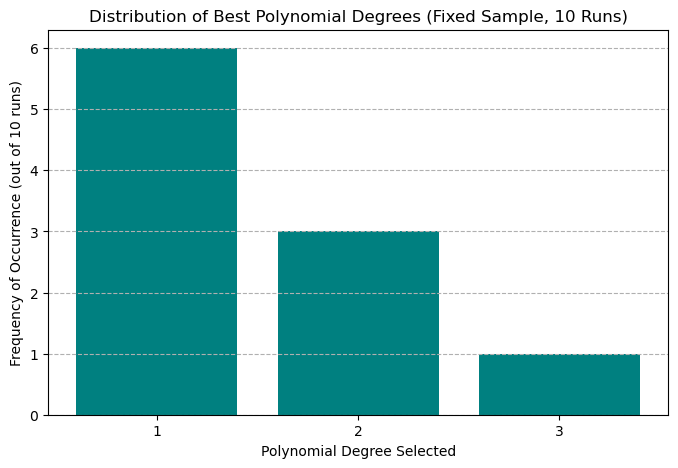

Frequency of each degree:
  Degree 1: 6 times
  Degree 2: 3 times
  Degree 3: 1 times

--- Comparison of Top 2 Most Frequent Degrees ---
Degree 1: selected 6 times, Average RMSE: 1.5888
Degree 2: selected 3 times, Average RMSE: 1.4834
✓ Degree 2 selected for having LOWER RMSE


In [9]:


print(f"Fixed raw sample created (size: {len(sampled_data_fixed)} rows).")


# --- STEP 2: ITERATION LOOP (Splitting & Preprocessing Inside) ---

for i in range(NUM_RUNS):
    # 1. DYNAMIC SPLIT (Source of Variability: The split changes every run)
    # This must use the fixed raw sample: sampled_data_fixed
    train_data_raw, val_data_raw, _ = train_validation_split(sampled_data_fixed)
    
    # 2. TRANSFORMATION (Post-Split Preprocessing)
    
    # Training Data Processing
    train_entry_processed = replicate_initial_position_by_block(train_data_raw)
    X_train_sampled = train_entry_processed[["t", "x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
    Y_train_sampled = train_data_raw[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values

    # Validation Data Processing
    val_entry_processed = replicate_initial_position_by_block(val_data_raw)
    X_val_sampled = val_entry_processed[["t", "x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
    Y_val_sampled = val_data_raw[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values

    # 3. FUNCTION CALL
    print(f"\n--- Run {i+1}/{NUM_RUNS} ---")
    best_rmse, best_degree = validate_poly_regression_v2(
        X_train_sampled,
        Y_train_sampled,
        X_val_sampled,
        Y_val_sampled
    )

    best_result.append((best_degree, best_rmse))


# --- STEP 3: FINAL ANALYSIS AND PLOT ---

best_degrees_distribution = [res[0] for res in best_result]
counts = np.bincount(best_degrees_distribution)
degrees = np.arange(len(counts))

# 1. Plotting the distribution
plt.figure(figsize=(8, 5))
plt.bar(degrees[1:], counts[1:], color='teal') 
plt.xlabel('Polynomial Degree Selected')
plt.ylabel(f"Frequency of Occurrence (out of {NUM_RUNS} runs)")
plt.xticks(degrees[1:])
plt.grid(axis='y', linestyle='--')
plt.title(f"Distribution of Best Polynomial Degrees (Fixed Sample, {NUM_RUNS} Runs)")
plt.show() 

# 1. Convert the list of results into a DataFrame for easier filtering
results_df = pd.DataFrame(best_result, columns=['Degree', 'RMSE'])

# 2. Find the two most frequent degrees
degree_counts = results_df['Degree'].value_counts()
print("Frequency of each degree:")
for degree, count in degree_counts.items():
    print(f"  Degree {degree}: {count} times")

# Get the two most frequent degrees
top_degrees = degree_counts.head(2).index.tolist()

if len(top_degrees) == 1:
    # Only one degree appeared
    best_selected_degree = top_degrees[0]
    average_rmse = results_df[results_df['Degree'] == best_selected_degree]['RMSE'].mean()
    print(f"\n--- Final Analysis ---")
    print(f"Only one degree selected across all runs: {best_selected_degree}")
    print(f"Average RMSE: {average_rmse:.4f}")
    
else:
    # Compare the two most frequent degrees
    degree1, degree2 = top_degrees
    rmse_degree1 = results_df[results_df['Degree'] == degree1]['RMSE']
    rmse_degree2 = results_df[results_df['Degree'] == degree2]['RMSE']
    
    avg_rmse_degree1 = rmse_degree1.mean()
    avg_rmse_degree2 = rmse_degree2.mean()
    
    print(f"\n--- Comparison of Top 2 Most Frequent Degrees ---")
    print(f"Degree {degree1}: selected {len(rmse_degree1)} times, Average RMSE: {avg_rmse_degree1:.4f}")
    print(f"Degree {degree2}: selected {len(rmse_degree2)} times, Average RMSE: {avg_rmse_degree2:.4f}")
    
    # Select the degree with the lowest average RMSE
    if avg_rmse_degree1 < avg_rmse_degree2:
        best_selected_degree = degree1
        best_avg_rmse = avg_rmse_degree1
        print(f"✓ Degree {degree1} selected for having LOWER RMSE")
    else:
        best_selected_degree = degree2
        best_avg_rmse = avg_rmse_degree2
        print(f"✓ Degree {degree2} selected for having LOWER RMSE")


--- Run 1/10 ---
Degree: 1, Number of features: 7
Degree: 2, Number of features: 35
Degree: 3, Number of features: 119
Degree: 4, Number of features: 329
Degree: 5, Number of features: 791
Degree: 6, Number of features: 1715
Degree: 7, Number of features: 3431
Degree: 8, Number of features: 6434

Best Degree: 1 with RMSE: 0.8174

--- Run 2/10 ---
Degree: 1, Number of features: 7
Degree: 2, Number of features: 35
Degree: 3, Number of features: 119
Degree: 4, Number of features: 329
Degree: 5, Number of features: 791
Degree: 6, Number of features: 1715
Degree: 7, Number of features: 3431
Degree: 8, Number of features: 6434

Best Degree: 8 with RMSE: 1.8903

--- Run 3/10 ---
Degree: 1, Number of features: 7
Degree: 2, Number of features: 35
Degree: 3, Number of features: 119
Degree: 4, Number of features: 329
Degree: 5, Number of features: 791
Degree: 6, Number of features: 1715
Degree: 7, Number of features: 3431
Degree: 8, Number of features: 6434

Best Degree: 7 with RMSE: 1.5152

---

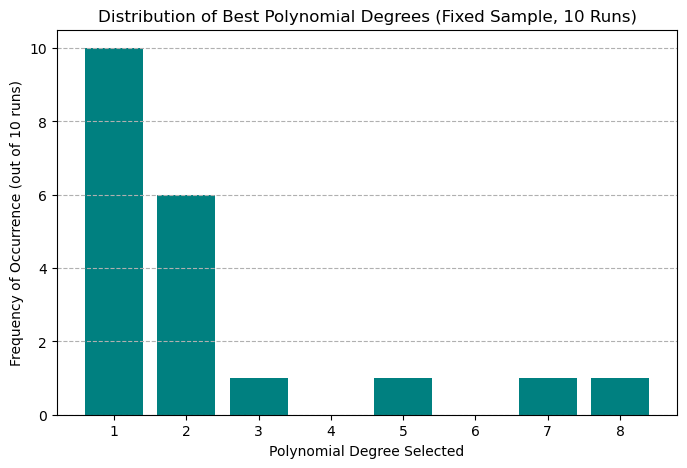

Frequency of each degree:
  Degree 1: 10 times
  Degree 2: 6 times
  Degree 3: 1 times
  Degree 8: 1 times
  Degree 7: 1 times
  Degree 5: 1 times

--- Comparison of Top 2 Most Frequent Degrees ---
Degree 1: selected 10 times, Average RMSE: 1.4487
Degree 2: selected 6 times, Average RMSE: 1.6096
✓ Degree 1 selected for having LOWER RMSE


In [10]:


# --- STEP 2: ITERATION LOOP (Splitting & Preprocessing Inside) ---
NUM_RUNS=10
for i in range(NUM_RUNS):
    # 1. DYNAMIC SPLIT (Source of Variability: The split changes every run)
    # This must use the fixed raw sample: sampled_data_fixed
    train_data_raw, val_data_raw, _ = train_validation_split(sampled_data_fixed)
    
    # 2. TRANSFORMATION (Post-Split Preprocessing)
    
    # Training Data Processing
    train_entry_processed = replicate_initial_position_by_block(train_data_raw)
    X_train_sampled = train_entry_processed[["t", "x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
    Y_train_sampled = train_data_raw[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values

    # Validation Data Processing
    val_entry_processed = replicate_initial_position_by_block(val_data_raw)
    X_val_sampled = val_entry_processed[["t", "x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values
    Y_val_sampled = val_data_raw[["x_1", "y_1", "x_2", "y_2", "x_3", "y_3"]].values

    # 3. FUNCTION CALL
    print(f"\n--- Run {i+1}/{NUM_RUNS} ---")
    best_rmse, best_degree = validate_poly_regression_v2(
        X_train_sampled,
        Y_train_sampled,
        X_val_sampled,
        Y_val_sampled,
        RidgeCV
    )

    best_result.append((best_degree, best_rmse))


# --- STEP 3: FINAL ANALYSIS AND PLOT ---

best_degrees_distribution = [res[0] for res in best_result]
counts = np.bincount(best_degrees_distribution)
degrees = np.arange(len(counts))

# 1. Plotting the distribution
plt.figure(figsize=(8, 5))
plt.bar(degrees[1:], counts[1:], color='teal') 
plt.xlabel('Polynomial Degree Selected')
plt.ylabel(f"Frequency of Occurrence (out of {NUM_RUNS} runs)")
plt.xticks(degrees[1:])
plt.grid(axis='y', linestyle='--')
plt.title(f"Distribution of Best Polynomial Degrees (Fixed Sample, {NUM_RUNS} Runs)")
plt.show() 

# 1. Convert the list of results into a DataFrame for easier filtering
results_df = pd.DataFrame(best_result, columns=['Degree', 'RMSE'])

# 2. Find the two most frequent degrees
degree_counts = results_df['Degree'].value_counts()
print("Frequency of each degree:")
for degree, count in degree_counts.items():
    print(f"  Degree {degree}: {count} times")

# Get the two most frequent degrees
top_degrees = degree_counts.head(2).index.tolist()

if len(top_degrees) == 1:
    # Only one degree appeared
    best_selected_degree = top_degrees[0]
    average_rmse = results_df[results_df['Degree'] == best_selected_degree]['RMSE'].mean()
    print(f"\n--- Final Analysis ---")
    print(f"Only one degree selected across all runs: {best_selected_degree}")
    print(f"Average RMSE: {average_rmse:.4f}")
    
else:
    # Compare the two most frequent degrees
    degree1, degree2 = top_degrees
    rmse_degree1 = results_df[results_df['Degree'] == degree1]['RMSE']
    rmse_degree2 = results_df[results_df['Degree'] == degree2]['RMSE']
    
    avg_rmse_degree1 = rmse_degree1.mean()
    avg_rmse_degree2 = rmse_degree2.mean()
    
    print(f"\n--- Comparison of Top 2 Most Frequent Degrees ---")
    print(f"Degree {degree1}: selected {len(rmse_degree1)} times, Average RMSE: {avg_rmse_degree1:.4f}")
    print(f"Degree {degree2}: selected {len(rmse_degree2)} times, Average RMSE: {avg_rmse_degree2:.4f}")
    
    # Select the degree with the lowest average RMSE
    if avg_rmse_degree1 < avg_rmse_degree2:
        best_selected_degree = degree1
        best_avg_rmse = avg_rmse_degree1
        print(f"✓ Degree {degree1} selected for having LOWER RMSE")
    else:
        best_selected_degree = degree2
        best_avg_rmse = avg_rmse_degree2
        print(f"✓ Degree {degree2} selected for having LOWER RMSE")